In [1]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
#zip_file_path = "waste_data/dataset.zip"
#extract_to = "waste_data"  # Adjust this path as needed

# Create the extraction directory if it doesn't exist
#os.makedirs(extract_to, exist_ok=True)

# Open and extract the zip file
#with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_to)

#print("Extraction completed!")


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths for original dataset and new folders
data_dir = 'waste_data'  # The original folder containing the category subfolders
base_dir = 'processed_waste_data'

# Create directories for train, val, and test
os.makedirs(base_dir, exist_ok=True)
for split in ['train', 'val', 'test']:
    for category in os.listdir(data_dir):
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Split data for each category
for category in os.listdir(data_dir):
    category_path = os.path.join(data_dir, category)
    images = os.listdir(category_path)
    
    # Check if there are enough images to split
    if len(images) < 4:  # Minimum number of images to split into train, val, and test
        print(f"Skipping category '{category}' due to insufficient images.")
        continue

    # Split into train, test, and val sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_images, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

    for image_set, split in [(train_images, 'train'), (val_images, 'val'), (test_images, 'test')]:
        for image in image_set:
            src_path = os.path.join(category_path, image)
            dest_path = os.path.join(base_dir, split, category, image)
            shutil.copyfile(src_path, dest_path)


Skipping category '.ipynb_checkpoints' due to insufficient images.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions and batch size
img_height, img_width = 150, 150
batch_size = 32

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test data for accurate performance evaluation
)

Found 1512 images belonging to 7 classes.
Found 507 images belonging to 7 classes.
Found 508 images belonging to 7 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\Ansh Patel\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,255 (18.42 MB)

 Trainable params: 4,829,255 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

C:\Users\Ansh Patel\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.2177 - loss: 1.9855 - val_accuracy: 0.3604 - val_loss: 1.5288
Epoch 2/20
 1/47 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.3125 - loss: 1.5257

C:\Users\Ansh Patel\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3125 - loss: 1.5257 - val_accuracy: 0.4815 - val_loss: 1.4281
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.3357 - loss: 1.5820 - val_accuracy: 0.4479 - val_loss: 1.3793
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3750 - loss: 1.5960 - val_accuracy: 0.3704 - val_loss: 1.5329
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4235 - loss: 1.4580 - val_accuracy: 0.4354 - val_loss: 1.4148
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5938 - loss: 1.3308 - val_accuracy: 0.3704 - val_loss: 1.4869
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4197 - loss: 1.4495 - val_accuracy: 0.4854 - val_loss: 1.3068
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5000 - loss: 1.2382 - val_accuracy: 0.4815 - val_loss: 1.3495
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.4813 - loss: 1.3022 - val_accuracy: 0.4958 - val_loss: 1.1936
Epo

In [6]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 827ms/step - accuracy: 0.4549 - loss: 1.2844
Test Accuracy: 45.28%


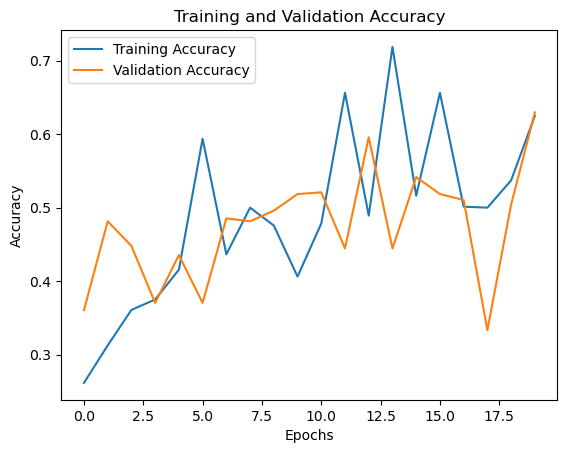

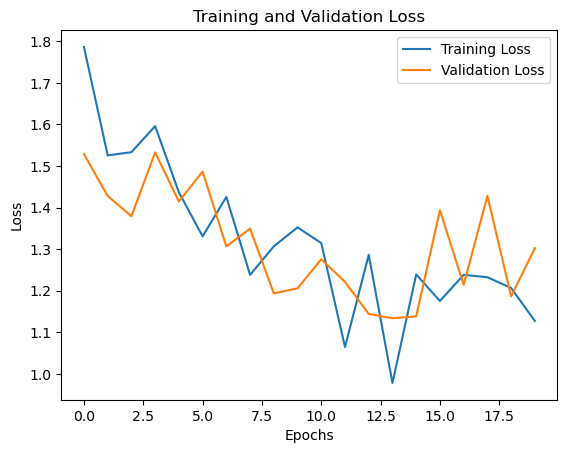

In [7]:
# Plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()